# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Introduction
        1.1. Cointegration for hand-made examples
        1.2. Half-life example
        1.3. Hurst exponent example
    2. Trading strategies
        2.1. Applying the Bollinger Bands strategy to the USO-GLD pair
        2.2. Applying the Kalman FIlter strategy to the EWA-EWC pair

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

# just set the seed for the random number generator
np.random.seed(107)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

### Import Configurations

In [23]:
with open('config.json', 'r') as f:
    config = json.load(f)

### Import Classes

In [26]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor(path=config['dataset']['path'])

## 1. Introduction

### 1.1. Cointegration for hand-made examples

### Example:

For two time series `A` and `B`:

In [5]:
# Define O(1) time series
A_returns = np.random.normal(0, 1, 1000)
A = pd.Series(np.cumsum(A_returns), name='A') + 50

# Define another time series
some_noise = np.random.exponential(1, 1000)
B = A - 7 + some_noise
B = pd.Series(B, name='B')

# Let's see if the two series are cointegrated
coint_result = series_analyzer.check_for_cointegration(X=A, Y=B)

A and B are cointegrated. The spread is stationary with p-value:  1.0


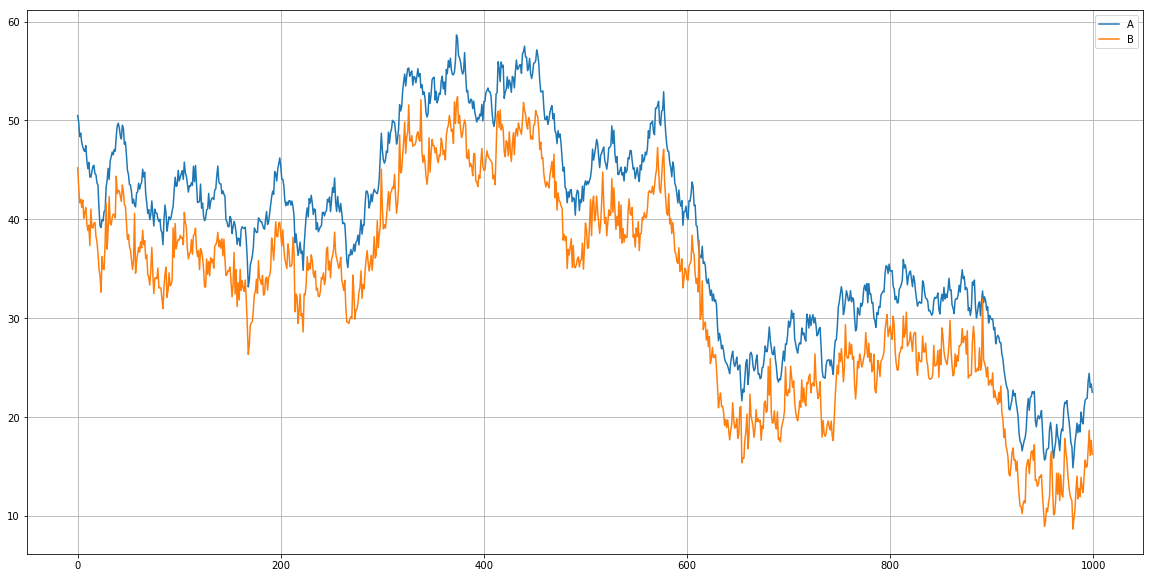

In [6]:
# evaluate results
confidence_level = 0.05
p_value = coint_result['p_value']

if p_value < confidence_level:
    print("A and B are cointegrated. The spread is stationary with p-value: ", 1-p_value)
else:
    print("A and B are not cointegrated. The spread is stationary with p-value:", 1-p_value)
    print(p_value)

pd.concat([A, B], axis=1).plot(figsize=(20, 10), use_index=True, grid=True);

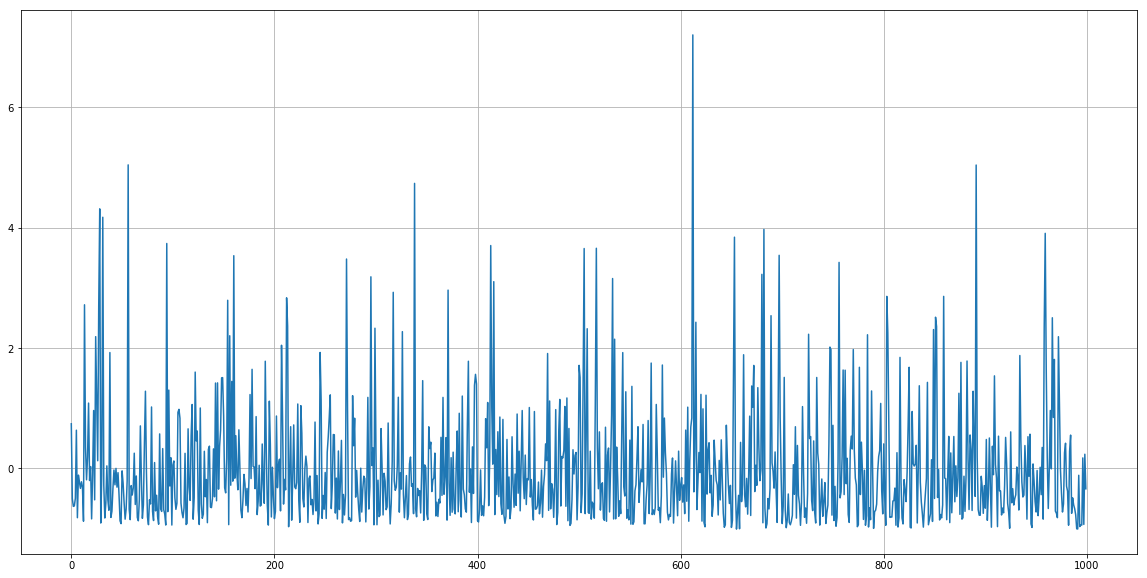

In [8]:
norm_spread = series_analyzer.zscore(coint_result['spread'])
norm_spread.plot(figsize=(20, 10), use_index=True, grid=True)

In [9]:
coint_result.keys()

dict_keys(['t_statistic', 'critical_val', 'p_value', 'coint_coef', 'zero_cross', 'half_life', 'spread', 'Y', 'X'])

### 1.2 Half-life

The half-life is a measurement of how long it takes for a series to mean revert. 

Ornstein-Uhlenbeck formula for mean-reverting process:

$$d y ( t ) = (\lambda y ( t - 1 ) + \mu ) d t + d \varepsilon$$

See: https://quant.stackexchange.com/questions/25086/calculating-half-life-of-mean-reverting-series-with-python

In [10]:
hf = series_analyzer.calculate_half_life(coint_result['spread'])

In [11]:
hf = series_analyzer.calculate_half_life(norm_spread)

### 1.3. Hurst Exponent

Generalized Hurst Exponent can be used to monitor the behaviour of a time-series.

In [12]:
#  Different types of time series for testing  
#p = np.log10(np.cumsum(np.random.randn(50000)+1)+1000) # trending, hurst ~ 1  
#p = np.log10((np.random.randn(50000))+1000)   # mean reverting, hurst ~ 0  
p = np.log10(np.cumsum(np.random.randn(50000))+1000) # random walk, hurst ~ 0.5  

In [13]:
series = coint_result['spread']
print(series_analyzer.hurst(series))

-0.004127641422241569


## 2. Trading strategies

Trading is done **out-of-sample**. Having identified the candidate pairs and modelled their spreads (by defining the independent variable), we proceed to continuosly update the spread model. Updating the spread implies:
- Recalculate cointegration ratio
- Recalculate mean & variance

### Simple Strategy:
* Go "Long" the spread whenever the z-score is below -1.0
* Go "Short" the spread when the z-score is above 1.0
* Exit positions when the z-score approaches zero

### Questions

- Not clear how the spread is supposed to be updated. For each new beta are we supposed to recalculate the spread? What if we just entetered a position because the updated spread was above the threshold and in the next step the update makes it go below the threshold again?

- The moving avg used to calculate the mean should be the same as the one used to calculate the spread. The one day moving average simply represents the current state of the spread.

### 2.1. Applying a Bollinger Band based strategy

Using the USO, GLD as example. The logic is that when oil prices rise, so does inflation and gold as consequence.

In [14]:
def read_pair(leg1, leg2, data_source, initial_date, final_date, close_type='Adj Close'):
    
    leg1_df = data.DataReader(leg1, data_source, initial_date, final_date)
    leg2_df = data.DataReader(leg2, data_source, initial_date, final_date)
    
    # filter columns of interest
    leg1_name = leg1 + "_close"
    leg2_name = leg2 + "_close"
    leg1_df = leg1_df[[close_type]].rename(columns={close_type: leg1_name})
    leg2_df = leg2_df[[close_type]].rename(columns={close_type: leg2_name})
    
    # concat in df
    pair_df = pd.concat([leg1_df, leg2_df], axis=1)
    
    # plot
    pair_df.plot(figsize=(20, 10), use_index=True, grid=True);
    
    return pair_df

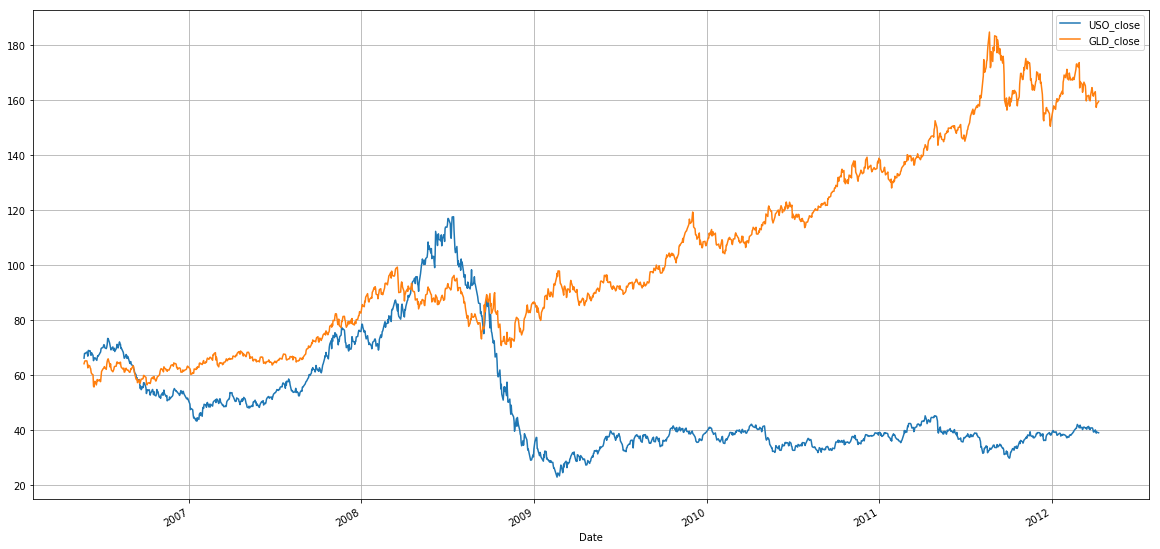

In [15]:
df_uso_gld = read_pair('USO','GLD', "yahoo", datetime(2006,5,24), datetime(2012,4,9))

In [16]:
# 1. Get best OLS regression
coint_uso_gld = series_analyzer.check_for_cointegration(X=df_uso_gld['GLD_close'], Y=df_uso_gld['USO_close'])

Testing the results: On 31-07 seems a good test

In [17]:
pnl, ret, summary, _ = trader.bollinger_band_strategy(Y=coint_uso_gld['Y'], X=coint_uso_gld['X'], lookback=20)

APR 0.1871291101255479
Sharpe 1.0169519074962339


With the dataset from GitHub:

In [383]:
# double check with git version
file_path = '../external/gld_uso.csv'
df_uso_gld = pd.read_csv(file_path)
df_uso_gld = df_uso_gld[['GLD', 'USO']]

# 1. Get best OLS regression
coint_uso_gld = series_analyzer.check_for_cointegration(X=df_uso_gld['GLD'], Y=df_uso_gld['USO'])

pnl, ret, summary, _ = trader.bollinger_band_strategy(coint_uso_gld['Y'], coint_uso_gld['X'], 20, 1, 0)

APR 0.19175226304892767
Sharpe 1.0414107351839874


In [19]:
summary.head(10)

,pnl_X,pnl_Y,pnl,ret,GLD,USO,spread,zscore,units
36,-0.000000,0.00,0.000000,0.000000,57.68,66.25,58.871310,NaN,0.0
37,0.000000,-0.00,0.000000,0.000000,56.36,65.54,56.398444,NaN,0.0
38,-0.000000,-0.00,-0.000000,0.000000,57.30,65.29,52.907888,NaN,0.0
39,-0.000000,0.00,0.000000,0.000000,58.33,66.35,51.068346,-1.033183,1.0
40,0.157192,0.65,0.807192,0.009888,57.73,67.00,50.812913,-0.968234,1.0
41,-0.072902,-0.11,-0.182902,-0.002199,57.99,66.89,49.456629,-1.050929,1.0
42,-0.087182,0.81,0.722818,0.008572,58.28,67.70,49.818158,-0.929244,1.0
43,0.184096,0.38,0.564096,0.006591,57.68,68.08,49.632915,-0.903893,1.0
44,0.044774,0.23,0.274774,0.003176,57.54,68.31,50.261840,-0.840425,1.0
45,-0.621052,1.20,0.578948,0.006704,59.52,69.51,50.393611,-0.858191,1.0


## Cumulative returns

The cumulative returns can be otained by constinuosly multiplying (1+ret).

In the end, subtract 1 and multiply by 100 to have the percentage.

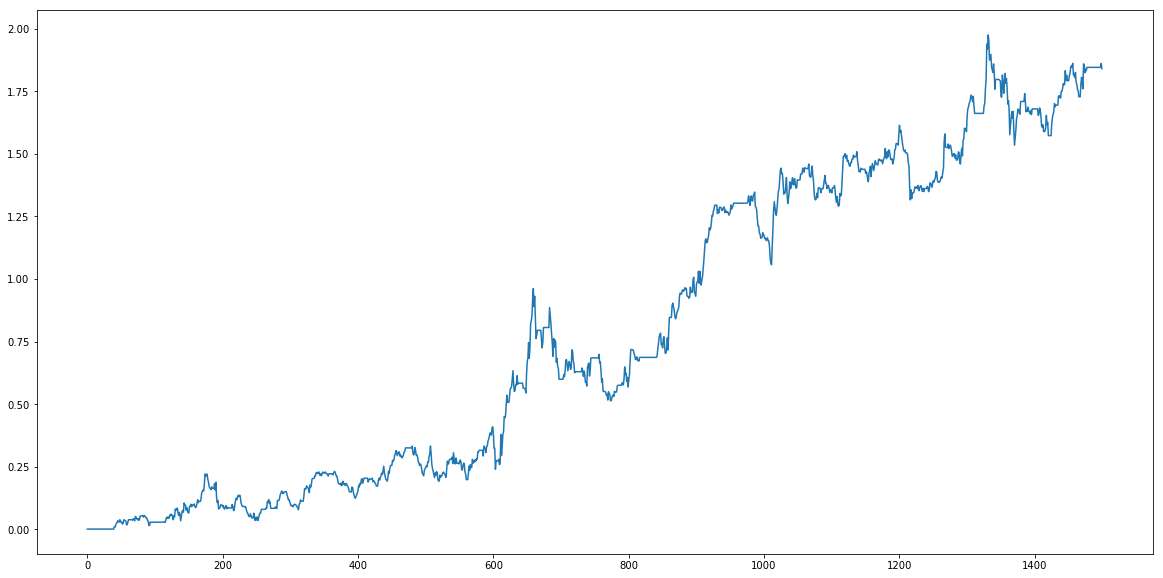

In [20]:
plt.figure(figsize=(20, 10))
plt.plot((np.cumprod(1+ret)-1))

### Summary:

- The spread acts as an indicator for the weight proportion of our bets. We should bet in Y and X with a ration $\beta$, because that's the ratio that guarantees mean reversion.

- We verify positive returns for the `GLD/USO` pair.

### 2.2. Applying the Kalman Filter

So how best to best estimate the current hedge ratio for a pair of real price series when it can vary with time? So far, we just took a moving look-back period and computed the regression coefficient over data in that period only. This has the disadvantage that if the look-back period is short, the deletion of the earliest bar and the inclusion of the latest bar as time moves forward can have an abrupt and artificial impact on the hedge ratio.We face the same problem if we use moving averages or moving standard deviations to calculate the current mean and standard deviation of a price series. 

In all cases, we may be able to improve the estimate by using a weighting scheme that *gives more weight to the latest data, and less weight to the earlier data*, without an arbitrary cutoff point. The familiar exponential moving average (EMA) is one such weighting scheme, but it is not clear why an exponential decrease in weights is optimal either. Here, we will describe a *scheme of updating the hedge ratio using the Kalman filter that avoids the problem of picking a weighting scheme arbitrarily (Montana,Triantafyllopoulos,andTsagaris,2009)*.

In [21]:
ewdf = pd.read_csv('../external/ETF.csv')
x = ewdf[['ewa']].copy()
y = ewdf[['ewc']].copy()

coint_ewa_ewc = series_analyzer.check_for_cointegration(x['ewa'], y['ewc'])

pnl, ret, _, _ = trader.kalman_filter(y= coint_ewa_ewc['Y'], x=coint_ewa_ewc['X'])

Ret:  0.0009446031992114527
Ret0:  0.0009446031992114527
1500
APR 0.262251943494046
Sharpe 2.3619490851761262


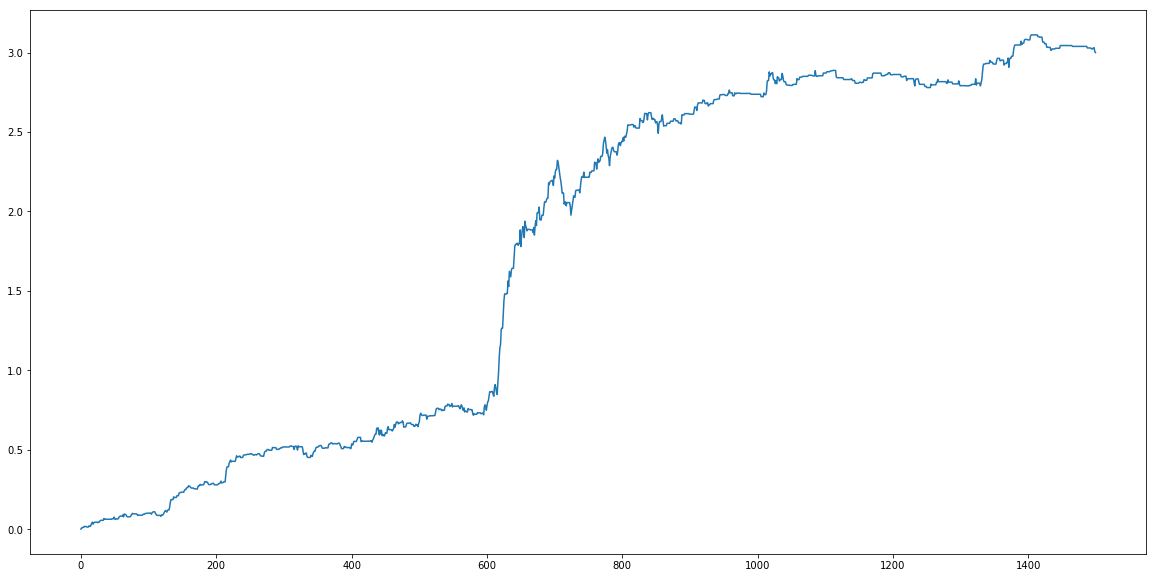

In [22]:
plt.figure(figsize=(20, 10))
plt.plot((np.cumprod(1+ret)-1))

However, when tested with USO GLD pair, the performance drops drastically...

In [24]:
# double check with git version
file_path = '../external/gld_uso.csv'
df_uso_gld = pd.read_csv(file_path)
df_uso_gld = df_uso_gld[['GLD', 'USO']]

# 1. Get best OLS regression
coint_uso_gld = series_analyzer.check_for_cointegration(X=df_uso_gld['GLD'], Y=df_uso_gld['USO'])

pnl, ret, _, _ = trader.kalman_filter(y=coint_uso_gld['Y'], x=coint_uso_gld['X'])

Ret:  0.00014770587102354461
Ret0:  0.00014770587102354461
1500
APR 0.03124938347994366
Sharpe 0.32765521601152325


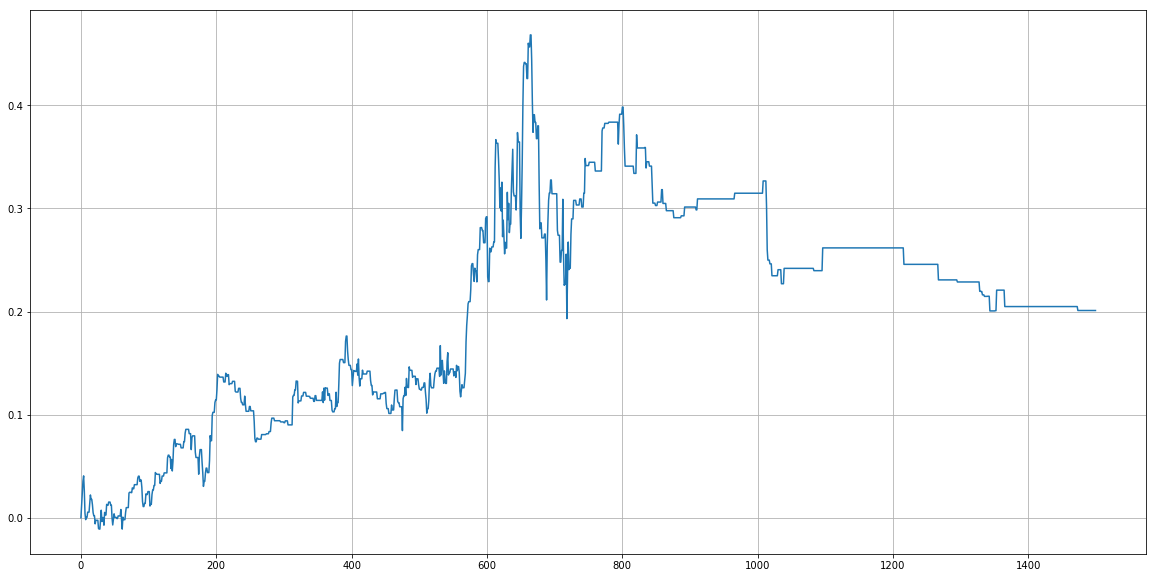

In [25]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot((np.cumprod(1+ret)-1))

## EWA - EWC example

Following the example from Earnie Chan's book - `Algorithmic Trading`.

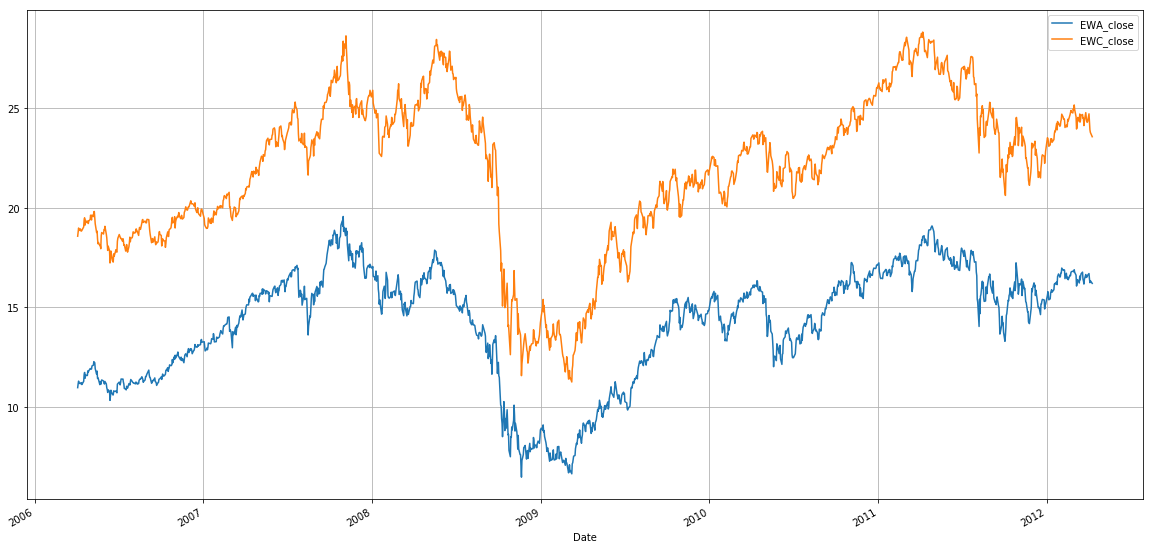

In [26]:
df_ewa_ewc = read_pair("EWA", "EWC", "yahoo",datetime(2006,4,4), datetime(2012,4,9))

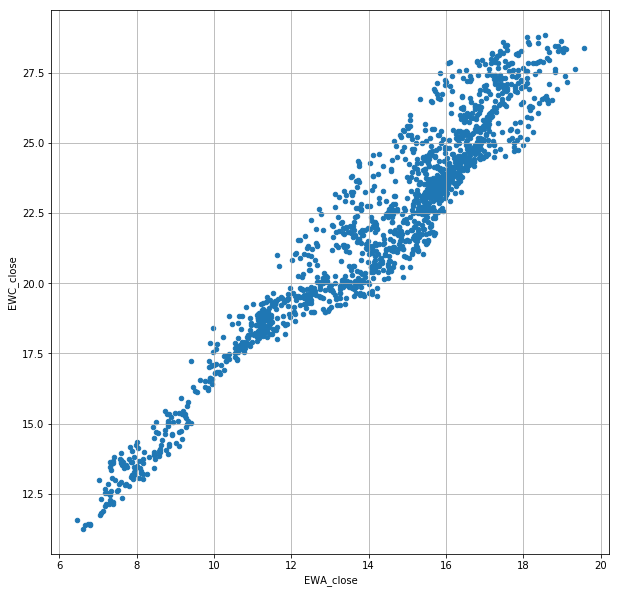

In [27]:
df_ewa_ewc.plot.scatter('EWA_close', 'EWC_close', figsize=(10, 10), use_index=True, grid=True)

**1) Cointegration:**

In [28]:
coint_ewa_ewc = series_analyzer.check_for_cointegration(df_ewa_ewc['EWA_close'], df_ewa_ewc['EWC_close'])

In [29]:
coint_ewa_ewc['t_statistic']

-3.245007334719016

In [30]:
coint_ewa_ewc['critical_val']

{'1%': -3.434685171403452,
 '10%': -2.5677893640196907,
 '5%': -2.863454705264858}

In [31]:
coint_ewa_ewc['p_value']

0.017522882085845137

**2) Half life mean-reversion**

In [32]:
hl = series_analyzer.calculate_half_life(coint_ewa_ewc['spread'])

**3) Hurst Exponent**

In [33]:
series_analyzer.hurst(coint_ewa_ewc['spread'])

0.41284535452684673

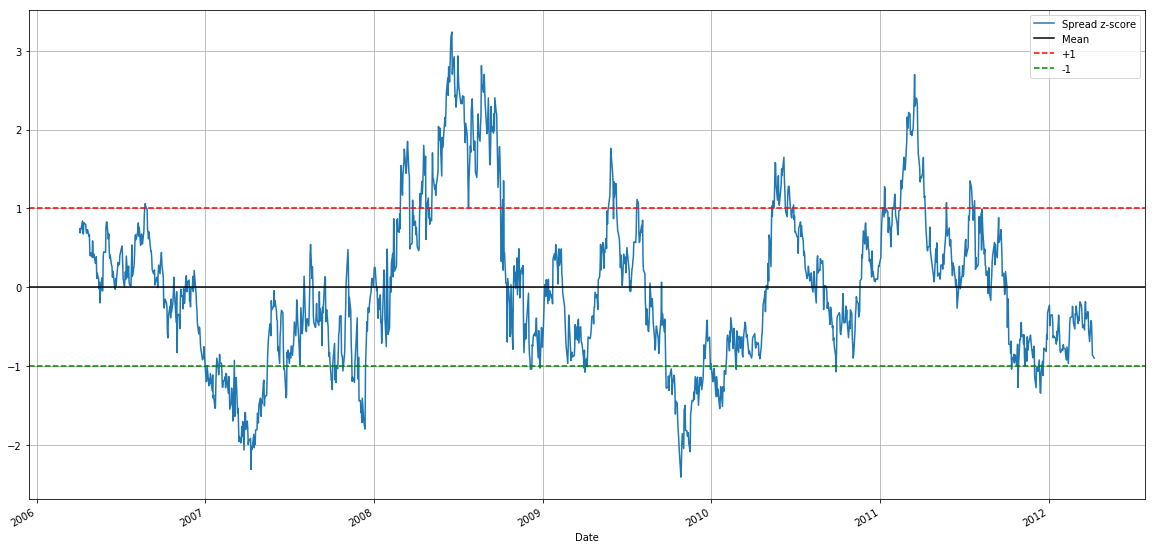

In [36]:
spread = coint_ewa_ewc['spread']
series_analyzer.zscore(spread).plot(figsize=(20, 10), use_index=True, grid=True)
plt.axhline(series_analyzer.zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

**4) Trading:**

In [37]:
pnl, ret, summary, _ = trader.bollinger_band_strategy(Y=coint_ewa_ewc['Y'], X=coint_ewa_ewc['X'], lookback=int(round(hl)))

APR 0.00830283640942664
Sharpe 0.1316874742439809


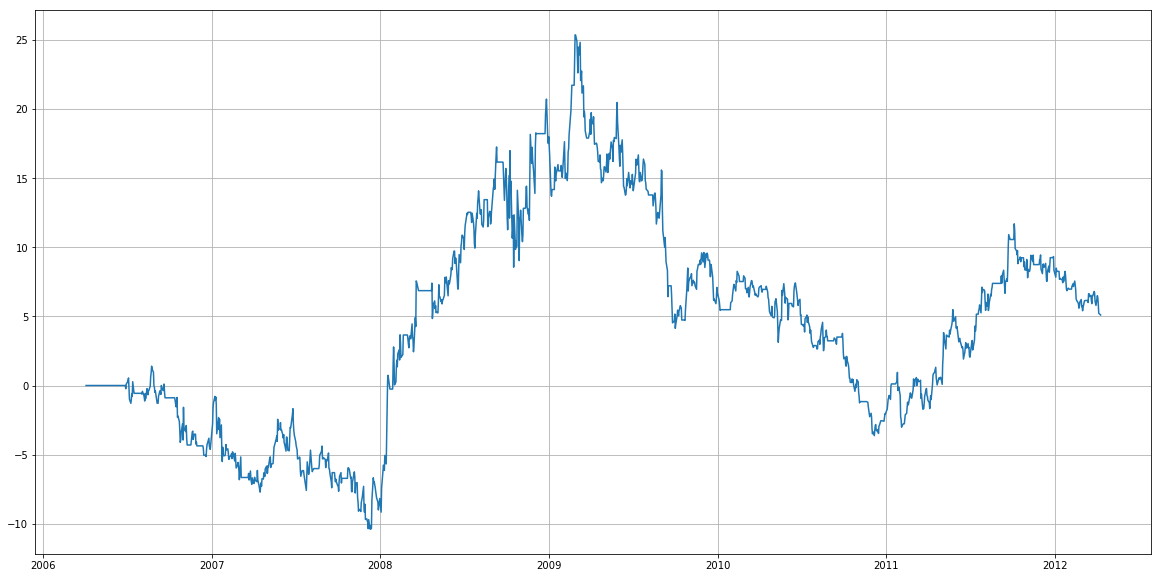

In [38]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot((np.cumprod(1+ret)-1) * 100)

# USD.CAD Example

Taken from Earnie Chan's book

In [39]:
usd_cad = data.DataReader("DEXCAUS", "fred", datetime(2007,7,22), datetime(2012,3,28))

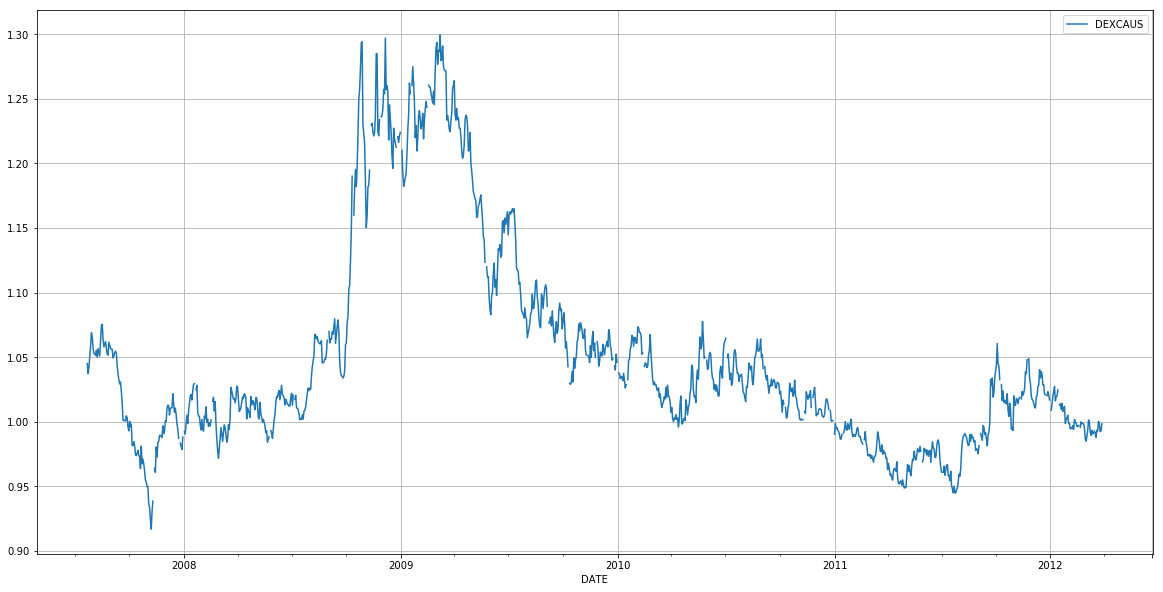

In [40]:
usd_cad.plot(figsize=(20, 10), use_index=True, grid=True)

In [41]:
usd_cad = usd_cad.dropna()
series_analyzer.check_for_stationarity(usd_cad['DEXCAUS'])

{'critical_values': {'1%': -3.435913333460925,
  '10%': -2.5680779665111078,
  '5%': -2.863996640985854},
 'p_value': 0.3413930952998334,
 't_statistic': -1.8802821581512863}

In [42]:
series_analyzer.hurst(np.log(usd_cad['DEXCAUS']))

0.45656233485210285

In [43]:
series_analyzer.calculate_half_life(usd_cad['DEXCAUS'])

112.51060646542004

## Hurst Exponent for Google

In [44]:
# Download the Google OHLCV data from 1/1/2000 to 1/1/2013
goog = data.DataReader("GOOG", "yahoo", datetime(2000,1,1), datetime(2013,1,1))

# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1
adfuller(goog['Adj Close'], 1)

(-2.1900105614322416,
 0.20989100364912439,
 0,
 2106,
 {'1%': -3.4334588739173006,
  '10%': -2.5675011176676956,
  '5%': -2.8629133710702983},
 12491.428049789843)

In [45]:
# Assuming you have run the above code to obtain 'goog'!
print("Hurst(GOOG):  %s" % series_analyzer.hurst(goog['Adj Close']))

Hurst(GOOG):  0.5078801187952492
